In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn 
import imblearn

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
fraud_detection = pd.read_csv('creditcard.csv')
fraud_detection.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

In [5]:
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, Dropout, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import KFold

#dividindo os dados em features e labels
X = fraud_detection.drop("Class", axis=1)
y = fraud_detection["Class"]

#padronizando os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [6]:
def create_classificador():
    classificador = Sequential()

    classificador.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=(30, 1)))
    classificador.add(BatchNormalization())
    classificador.add(Dropout(0.5))
    classificador.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=(30, 1)))
    classificador.add(BatchNormalization())
    classificador.add(MaxPooling1D(pool_size = (2)))
    classificador.add(Dropout(0.25))
    classificador.add(Flatten())

    classificador.add(Dense(32, activation='relu'))
    classificador.add(Dropout(0.2))
   
    classificador.add(Dense(1, activation='sigmoid'))

    classificador.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classificador

#Definindo número de folds
n_folds = 5

#Inicializando lista para armazenar resultados de validação
results = []

#Criando objeto KFold
kfold = KFold(n_folds, shuffle=True, random_state=0)

# Loop para cada fold
for train_index, val_index in kfold.split(X, y):
    #dividindo dados em treino e validação
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    #adicionando uma dimensão adicional na sua entrada, usando o método reshape()
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

    
    #Criando o modelo classificador CNN
    classificador = create_classificador()

    #Treinando o modelo com o conjunto de treinamento e validação
    history = classificador.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=14, batch_size = 256, verbose=0)

    #Avaliando modelo
    result = classificador.evaluate(X_val, y_val)

    #Armazenar os resultados (acurácia)
    results.append(result)

# Imprimir resultados médios
print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(results, axis=0)[1]*100, np.std(results, axis=0)[1]*100))


1781/1781 [==============================] - 1s 710us/step - loss: 0.0026 - accuracy: 0.9994
Accuracy: 99.94% (+/- 0.00%)


Aqui, o método KFold é usado para dividir o conjunto de dados em n_folds (no seu caso, 5) partes. Em seguida, um loop é executado para cada fold, com os dados de treinamento e validação sendo separados para cada iteração. O modelo CNN é treinado e avaliado com o conjunto de treinamento e validação, respectivamente, e a acurácia é armazenada na lista results. Finalmente, a acurácia média e a variância são impressas.

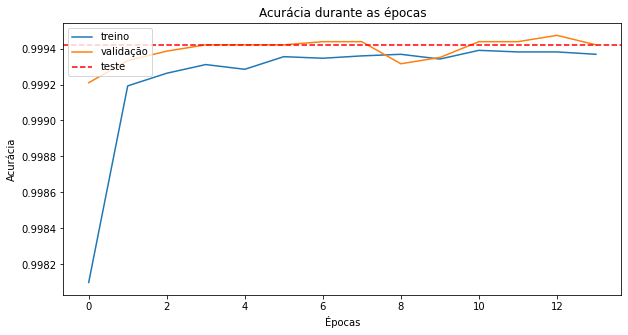

In [7]:
#Plots da acurácia do modelo
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'],label = 'treino')
plt.plot(history.history['val_accuracy'],label = 'validação')
plt.axhline(y=result[1], color='r', linestyle='--',label = 'teste')
plt.title('Acurácia durante as épocas')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(loc='upper left')

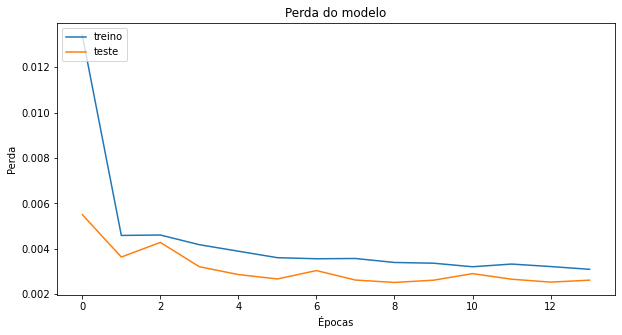

In [8]:
#Plots do valor de perda do modelo
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do modelo')
plt.ylabel('Perda')
plt.xlabel('Épocas')
plt.legend(['treino', 'teste'], loc='upper left')

In [9]:
#probabilidades de predição de cada classse (valores)
y_predicted_probs = classificador.predict(X_val)
y_predicted_probs

array([[1.20439609e-05],
       [9.69381472e-06],
       [7.67638121e-05],
       ...,
       [6.26470910e-06],
       [2.13230373e-06],
       [1.30924855e-05]], dtype=float32)

In [10]:
#probabilidades de cada classse (labels) analisar a linha de classificação
y_predicted = (classificador.predict(X_val) > 0.6).astype("int32").ravel()
y_predicted

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

In [12]:
# Calcule as métricas de avaliação
precision = precision_score(y_val, y_predicted)
recall = recall_score(y_val, y_predicted)
f1 = f1_score(y_val, y_predicted)
ballance_accuracy = balanced_accuracy_score(y_val, y_predicted)
accuracy = accuracy_score(y_val, y_predicted)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_val, y_predicted, average='macro')
roc_auc = roc_auc_score(y_val, y_predicted)

In [13]:
print('Precision:\n', precision, sep='\t')
print('Recall:\n', recall, sep='\t')
print('F1 Score:\n', f1,sep='\t')
print('Balanced Accuracy:\n', ballance_accuracy,sep='\t')
print('Precision Macro:\n', precision_macro, sep='\t')
print('Accuracy:\n', accuracy,sep='\t')
print('Precision Macro:\n', precision_macro, sep='\t')
print('Recall Macro:\n', recall_macro, sep='\t')
print('F1 Macro:\n', f1_macro, sep='\t')
print('ROC AUC:\n', roc_auc,sep='\t')

Precision:
	0.9113924050632911
Recall:
	0.7128712871287128
F1 Score:
	0.8
Balanced Accuracy:
	0.8563740888686124
Precision Macro:
	0.955441288850692
Accuracy:
	0.9993679886237953
Precision Macro:
	0.955441288850692
Recall Macro:
	0.8563740888686124
F1 Macro:
	0.8998417471118847
ROC AUC:
	0.8563740888686124


In [14]:
metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'Balanced Accuracy': ballance_accuracy,
    'Accuracy': accuracy,
    'Macro Precision': precision_macro,
    'Macro Recall': recall_macro,
    'Macro F1-score': f1_macro,
    'ROC AUC': roc_auc
}

metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Resultados'])
print(metrics_df)

                   Resultados
Precision            0.911392
Recall               0.712871
F1-score             0.800000
Balanced Accuracy    0.856374
Accuracy             0.999368
Macro Precision      0.955441
Macro Recall         0.856374
Macro F1-score       0.899842
ROC AUC              0.856374


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [17]:
print(classification_report(y_val, y_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.91      0.71      0.80       101

    accuracy                           1.00     56961
   macro avg       0.96      0.86      0.90     56961
weighted avg       1.00      1.00      1.00     56961



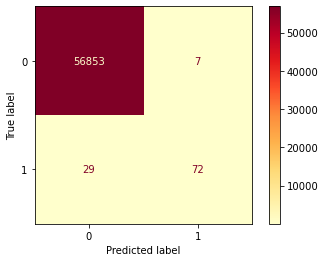

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_val, np.around(y_predicted))
display = ConfusionMatrixDisplay(cm)
display.plot(cmap=plt.cm.YlOrRd)
plt.grid(False)
plt.show()

Utilizei a função numpy.where para verificar se os valores previstos são iguais aos valores verdadeiros.

In [19]:
# Contagem de valores previstos corretamente
correct = np.sum(np.where(y_predicted == y_val, 1, 0))
print("Contagem de valores previstos classificados corretamente:", correct)

Contagem de valores previstos classificados corretamente: 56925


In [20]:
# contagem de valores previstos incorretamente
incorrect = np.sum(np.where(y_predicted != y_val, 1, 0))

print("Contagem de valores previstos classificados incorretamente:", incorrect)

Contagem de valores previstos classificados incorretamente: 36


Nesse exemplo, temos dois arrays: y_test que representa as classes verdadeiras e y_pred que representa as classes previstas pelo nosso modelo de aprendizagem de máquina. Utilizamos a função np.where para comparar cada elemento dos arrays e, se o valor previsto é igual ao valor verdadeiro, adicionamos 1 à contagem. A mesma coisa é feita para saber os que foram classificados incorretamente. No final, imprimimos a contagem de valores previstos corretamente. E se notar, é possível ver esses valores na matriz de confusão.

#### Salvando os resultados em um CSV

In [15]:
# Salve o DataFrame em um arquivo CSV
metrics_df.to_csv('results_tentativas_KFOLD_CNN.csv', index=False)